<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [12]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выборка достаточно маленькая,однако, в силу того что мы используем ResNet50, предобученную на датасете ImageNet нам это не должно помешать. Однако, если предобученной нейросети нет, это может плохо сказаться на обучении, модель может недообучиться.

In [14]:
df.shape

(7591, 2)

In [15]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


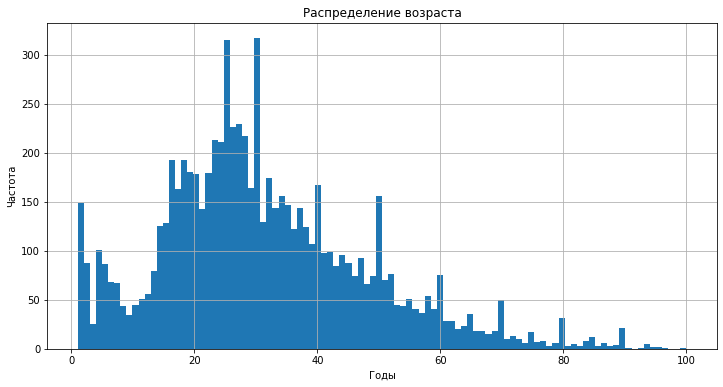

In [30]:
df.hist(bins = 100, figsize = (12,6))
plt.title("Распределение возраста")
plt.xlabel('Годы')
plt.ylabel('Частота')
plt.show()

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=True,
        seed=12345)

Found 7591 validated image filenames.


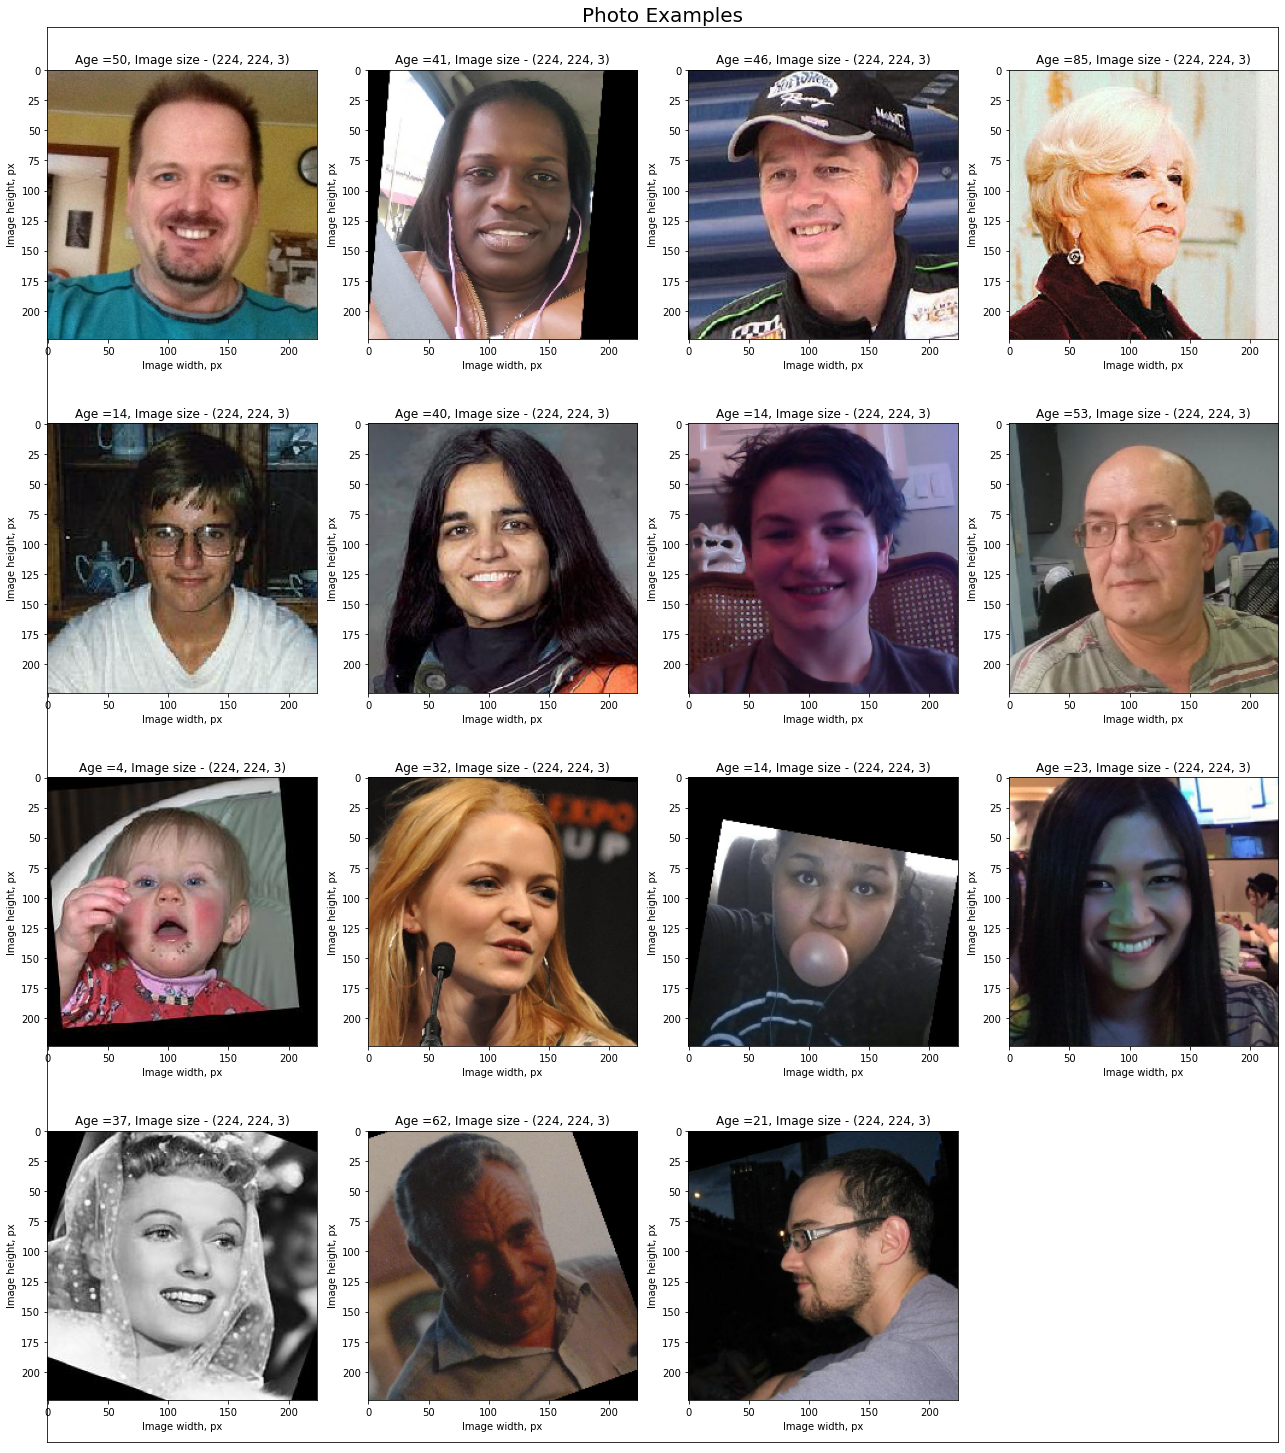

In [18]:
features, target = next(train_gen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20,
 'fontweight' : 10,
 'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout() 
    plt.title('Age ={}, Image size - {}'.format(target[i], features[i].shape), loc='center')    
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

Много фотографий повёрнуто и на них есть тёмные пятна, из-за этого у модели могут быть проблемы с распознаванием. Так же на фотографиях практически нет мужчин с бородой, это тоже может стать камнем преткновения. Некоторые фотографии повёрнуты, возможно, стоит перед обучением модели их перевернуть. Так же есть чёрно-белые изображения, это можно исправить, приведя все фотографии к чёрно-белым. Так же некоторые фотографии меньше других, это тоже может повлиять на модель.

## Обучение модели

In [15]:
def load_train(path):

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    
    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Train for 190 steps, validate for 48 steps
Epoch 1/5
190/190 - 47s - loss: 217.8566 - mae: 10.5081 - val_loss: 684.1026 - val_mae: 21.0763
Epoch 2/5
190/190 - 39s - loss: 57.5821 - mae: 5.7519 - val_loss: 724.8105 - val_mae: 21.7569
Epoch 3/5
190/190 - 39s - loss: 32.3452 - mae: 4.3850 - val_loss: 405.8709 - val_mae: 15.1207
Epoch 4/5
190/190 - 38s - loss: 20.8052 - mae: 3.5106 - val_loss: 98.4590 - val_mae: 7.4451
Epoch 5/5
190/190 - 40s - loss: 15.1910 - mae: 3.0364 - val_loss: 78.5135 - val_mae: 6.8546
```

Получено необходимое значение MAE

## Анализ обученной модели

Использованная сеть ResNet50 за малое количество эпох достигает необходимой нам метрики MAE равной 6.85. Если увеличить количество эпох, возможно, что MAE снизится ещё. Так же модель довольно быстро обучается и довольно быстро сходится. Думаю, что заранее инициализированные веса с помощью ImageNet сильно помогли в скорости. Возможно,стоить поиграться с ориентацией фотографий, с их цветом и размером и выжать из этого идеальную точность. 

Данная модель, выведенная в продакшен, может помочь бизнесу определять возраст покупателей на кассах для того чтобы не продавать совершеннолетним алкоголь, так же может помочь в собрании статистики средснестатистического возраста покупателя какой-либо сети магазинов и лучше подстраивать магазин под этого покупателя и получить большую прибыль. 